# Dynamic Analysis of the non-motorized mechanisms for human lower limb rehabilitation

The main reference of this work is described [here](https://repositorio.ufu.br/handle/123456789/18982) in portuguese (english version coming soon).

This work is a complementary file for the mathematical model of non-motorized mechanisms developed to perform rehabilitation exercises for the human lower limb. There are three designs, one for each joint of the lower limb (hip, knee and ankle). The mechanisms are based on the crank-rocker fourbar linkage, with geometrics designed to match the flexion-extension angular amplitude of each joint on the follower bar. In this notebook, we implement a Finite Element Analysis (FEA) to identificate the Frequency Response Function (FRF) of the mechanisms on each position. 

This analysis will be performed for each mechanism separately.


In [3]:
#importing the libs
%matplotlib inline
import numpy as np
from numpy.matlib import eye
from scipy import linalg as LA
from math import cos, sin, tan, pi, atan, radians
import pandas as pd
import matplotlib.pyplot as plt


## Knee Mechanism

The first mechanism to be analyzed is the one designed for the knee flexion-extesion. The analysis starts with the definition of the **physical and geometrical** parameters that define the configuration of the mechanisms.

In [2]:
E=69e7 # Elasticity modulus N/m^2
rho=2700 # Volumetrical density kg/m^3
A = (1e-3*25.4)*(1e-3*12.7)-(1e-3*(25.4-5))*(1e-3*(12.7-5)) # area of the transversal section m^2
inertia = (((1e-3*12.7)*(1e-3*25.4)**3)/12)-((1e-3*(12.7-5)*(1e-3*(25.4-5))**3)/12) #Inertia of the transversal section kg m^2 

lengths = np.array([0.140,0.263,0.143,0.143]) # Bar Lengths (m). IMPORTANT: We treated the extension of the follower bar as separate bar in the FEA.
angles= np.array([0.997609, 0.130134,1.213225,1.213225]) #bar orientations (rad)

P = 264.87 #External Load (N)

The main goal of this analysis is to obtain the FRF of the mechanisms along its workspace. Thus, it is essential that the calculated natural frequencies are as close as desired to the real frequencies of the configuration.
To ensure this condition, an iterative refination process is applied to the finite element construction process in order to find a mesh with a relative error not greater than 0.1% of the first 6 natural frequencies.

To do that, we defined the following function called ```fea_natural_frequencies()```, which calculates the natural frequencies based on the physical properties of the mechanism and its instantaneous orientation.

Although the function is able to calculate the entire FRF, we are interested in 2 specific points:
 - The null frequency (0 Hz), which represents the static solution;
 - The expected maximum operational frequency for the mechanisms, which is estimated to be 0.2 Hz.


In [13]:
def fea_natural_frequencies(L ,orientations):
    
    FE_per_bar=0           #number of finite elements per bar of the mechanism. Initialized as zero, and increased on the loop
    f_nat=np.ones(6)        #array to keep the first 6 natural frequencies on the current FE configuration.
    f_prev=np.zeros(6)      #array to keep the first 6 natural frequencies on the previous FE configuration.
    error=1e-3              #limit of the relative error
    
    while (max(abs(f_nat-f_prev)) > error) or (FE_per_bar < 20):
        f_prev=f_nat[0:5]
    
        FE_per_bar=FE_per_bar+1  #nEFbarr
        number_of_bars=len(L) #number of bars 
        number_of_FE=FE_per_bar*number_of_bars #nEF
        number_of_nodes=number_of_FE+1 #nNo 
        DOF_per_node=3 #gdn

        boundary_nodes = np.array([0,FE_per_bar*3]) #nodes with imposed boundary conditions (displacement = 0)
        loaded_nodes = np.array([number_of_FE]) #nodes with external load

        FE_length = L/(FE_per_bar*np.ones(number_of_bars,dtype=int))
        FE_properties = np.zeros((3,number_of_FE))

        aux = 0 #auxiliar integer to delimiter each bar on the properties matrix
        for ii in range(number_of_bars):
            for jj in range(FE_per_bar):
                FE_properties[0,jj+aux] = FE_length[ii]     #Assign FE length on the properties matrix
                FE_properties[1,jj+aux] = orientations[ii]  #Assign FE orientation on the properties matrix
                FE_properties[2,jj+aux] = inertia           #Assign FE inertia on the properties matrix
            aux = aux + FE_per_bar    

        #connectivity matrix (defines the nodes that form each element)
        connectivity_matrix = np.zeros((number_of_FE,2),dtype=int)
        connectivity_matrix[0] =[0,1]
        for ii in range(1,number_of_FE):
            connectivity_matrix[ii] = connectivity_matrix[ii-1] + [1,1]
        connectivity_matrix[FE_per_bar*3,0] = connectivity_matrix[FE_per_bar*2-1,1]

        #number of Degrees of freedom (global)
        number_of_DOF = number_of_nodes*DOF_per_node
        DOF_matrix = np.arange(number_of_DOF).reshape((number_of_nodes,DOF_per_node))

        connectivity_of_DOFs = np.zeros((number_of_FE,2*DOF_per_node))
        for ii in range(number_of_FE):
            connectivity_of_DOFs[ii] = np.concatenate((DOF_matrix[connectivity_matrix[ii,0]],DOF_matrix[connectivity_matrix[ii,1]]),axis=None)

        connectivity_of_DOFs = connectivity_of_DOFs.astype(int)

        #mechanical system Analysis
        identity_matrix = eye(number_of_DOF)
        M_global = np.zeros((number_of_DOF,number_of_DOF)) #Inertia Matrix
        K_global = np.zeros((number_of_DOF,number_of_DOF)) #Stiffness Matrix

        for ii in range(number_of_FE):
            l=FE_properties[0,ii] #length of the iterated element
            I=FE_properties[2,ii] #Inertia of the iterated element

            #Elementary stiffness on axial direction (X)
            K_elementary_u= E*A/l*np.array([[1, 0, 0, -1, 0, 0],
                                        [0, 0, 0, 0, 0, 0],
                                        [0, 0, 0, 0, 0, 0],
                                        [-1, 0, 0, 1, 0, 0],
                                        [0, 0, 0, 0, 0, 0],
                                        [0, 0, 0, 0, 0, 0]])

            #Elementary stiffness on transversal direction (Y)
            K_elementary_v=E*I/(l**3)*np.array([[0, 0, 0, 0, 0, 0],
                                            [0, 12, 6*l, 0, -12, 6*l],
                                            [0, 6*l, 4*l**2, 0 , -6*l, 2*l**2],
                                            [0, 0, 0, 0, 0, 0],
                                            [0, -12, -6*l, 0, 12, -6*l],
                                            [0, 6*l, 2*l**2, 0 , -6*l, 4*l**2]])
            #Elementary mass matrix
            M_elementary=rho*A*l/420*np.array([[140, 0, 0, 70, 0, 0],
                                 [0, 156, 22*l, 0, 54, -13*l],
                                 [0, 22*l, 4*l**2, 0, 13*l, -3*l**2],
                                 [70, 0, 0, 140, 0, 0],
                                 [0, 54, 13*l, 0, 156, -22*l],
                                 [0, -13*l, -3*l**2, 0, -22*l, 4*l**2]])

            #transformation matrix for orientation
            angle =FE_properties[1,ii]
            Tranform_orientation = np.array([[cos(angle),sin(angle),0,0,0,0],
                                        [-sin(angle),cos(angle),0,0,0,0],
                                        [0,0,1,0,0,0],
                                        [0,0,0,cos(angle),sin(angle),0],
                                        [0,0,0,-sin(angle),cos(angle),0],
                                        [0,0,0,0,0,1]])
            K_elementary_transformed = Tranform_orientation.transpose().dot(K_elementary_u+K_elementary_v).dot(Tranform_orientation)
            M_elementary_transformed = Tranform_orientation.transpose().dot(M_elementary).dot(Tranform_orientation)
            transform_matrix = identity_matrix[connectivity_of_DOFs[ii,0],:]
            for jj in range(1,2*DOF_per_node):
                transform_matrix= np.concatenate((transform_matrix,identity_matrix[connectivity_of_DOFs[ii,jj],:]))
            M_global = M_global + transform_matrix.transpose().dot(M_elementary_transformed).dot(transform_matrix)
            K_global = K_global + transform_matrix.transpose().dot(K_elementary_transformed).dot(transform_matrix)

        #applying the boundary conditions:
        DOF_with_boundary_conditions = DOF_matrix[boundary_nodes].ravel()
        DOF_with_boundary_conditions = DOF_with_boundary_conditions[0:-1]

        #applying the External Forces:
        DOF_with_external_forces = DOF_matrix[loaded_nodes,1]
        DOF_with_external_forces

        #Building the global Forces Array:
        F_global = np.zeros(number_of_DOF)
        F_global[DOF_with_external_forces] = P

        #Eliminating the Known equations from the Mass and Stiffness matrices:
        M_global = np.delete(M_global,DOF_with_boundary_conditions,0)
        M_global = np.delete(M_global,DOF_with_boundary_conditions,1)

        K_global = np.delete(K_global,DOF_with_boundary_conditions,0)
        K_global = np.delete(K_global,DOF_with_boundary_conditions,1)

        F_global = np.delete(F_global,DOF_with_boundary_conditions,0)

        #Solving the eigenvalues and eigenvectors problem
        eig_values,eig_vectors = LA.eig(K_global,M_global)
        natural_frequencies_radians = np.sort(eig_values.real,axis=0)**0.5
        natural_frequencies_herts = natural_frequencies_radians/(2*pi)

        f_nat=natural_frequencies_herts[0:5]
        
        #FRF response
        expected_frequency = 0.2 #hertz
        freq=np.array([0, expected_frequency]) #first value is zero to represent the static response, second value is the expected frequency of the mechanisms
        #df=(freq[-1]-freq[0])/(len(freq)-1)
        w=2*pi*freq

        H=np.zeros(len(freq))
        for ii in range(len(freq)):
            Transfer_function = np.linalg.inv(K_global-w[ii]**2*M_global)
            H[ii] = F_global.transpose().dot(Transfer_function).dot(F_global)

        reference=1e-6
        H = 20*np.log10(abs(H)/reference)
        

        
    return [f_nat, H]


### Importing the mechanism configurations as a DataFrame
With the main analysis function created, we can import the angular trajectory of the knee mechanism as an Pandas DataFrame and use the data to obtain the variation of the natural frequencies and the FRF.


In [ ]:
#Importing the CSV
knee_data = pd.read_csv('Data/knee_data.csv',skipinitialspace=True)
knee_data = knee_data.drop(['input_torque'],axis=1)

#calculating the natural frequencies
first_natural_frequency = list()
estatic_response = list()
operational_response = list()

for ii in range(knee_data.shape[0]):
    print(f"calculating postition {ii} out of {knee_data.shape[0]}.")
    for jj in range(knee_data.shape[1]):
        angles[jj] = knee_data.iloc[ii,jj]

    angles[-1] = angles[-2]  #since the bar 4 is represented as 2 bars on this analysis, this step is necessary to assign the correct orientation on all elements
    
    [natural_frequencies,frequency_response] = fea_natural_frequencies(lengths,angles)
    first_natural_frequency.append(natural_frequencies[0])
    estatic_response.append(frequency_response[0])
    operational_response.append(frequency_response[1])
    


### Creating the plots

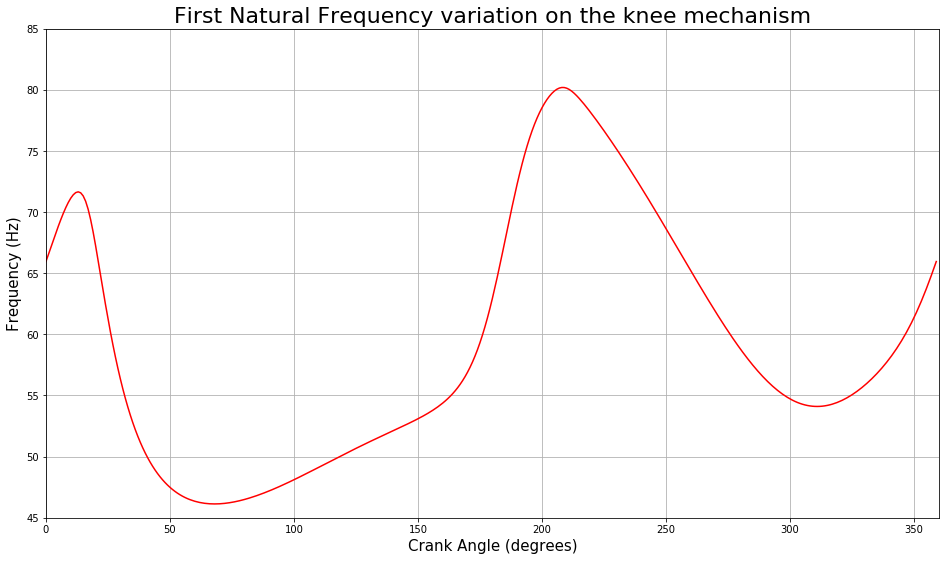

In [96]:
input_angle_in_degrees = np.arange(360)


fig, ax = plt.subplots(figsize=(16,9))


ax.plot(input_angle_in_degrees,first_natural_frequency,'r')
ax.set_xlim([0, 360])
ax.set_ylim([45, 85])
ax.set_title('First Natural Frequency variation on the knee mechanism',Fontsize=22)
ax.set_xlabel('Crank Angle (degrees)', Fontsize=15)
ax.set_ylabel('Frequency (Hz)', Fontsize=15)
ax.grid()

plt.show()

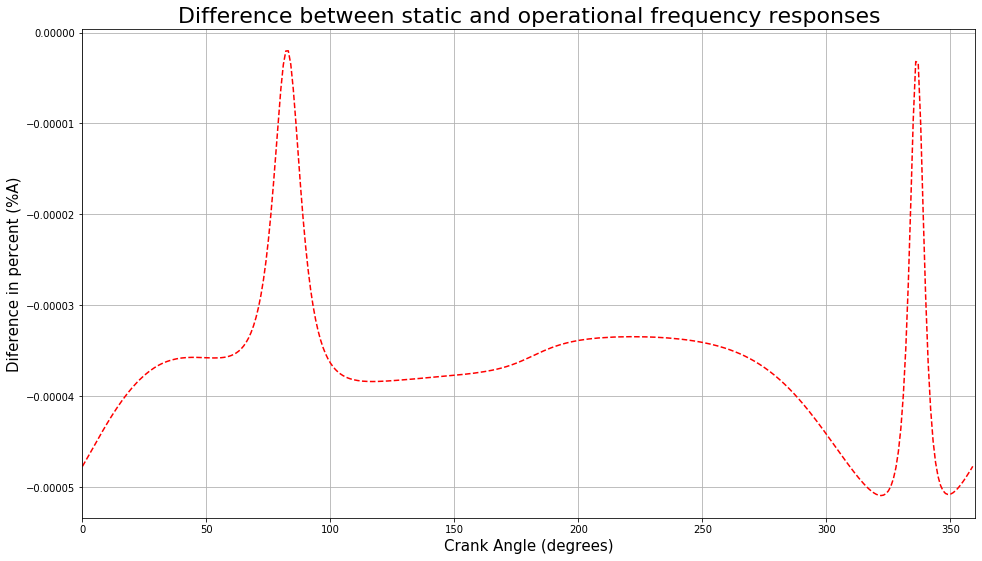

In [107]:
fig, ax = plt.subplots(figsize=(16,9))

response_difference = np.divide(np.array(estatic_response) - np.array(operational_response),np.array(estatic_response))*100

ax.plot(input_angle_in_degrees,response_difference,'r')
ax.set_xlim([0, 360])
ax.set_title('Difference between static and operational frequency responses',Fontsize=22)
ax.set_xlabel('Crank Angle (degrees)', Fontsize=15)
ax.set_ylabel('Diference in percent (%)', Fontsize=15)
ax.grid()

plt.show()

As we can see on the plots above, the natural frequencies of the structure oscilate throughout the configurations on the workspace, with the lowest one varying from arround 45 to 85 Hz. Our operational frequency is expected to be up to 0.2 Hz, which is relatively far from the fisrt frequency in any points of the workspace. Thus, it is expected to have low diferences between the static response of the mechanism and the operational frequency. This expectation is confirmed on the second plot, where we get a maximum difference of $5 \cdot 10^{-6}$ dB between the responses. 

# Hip Mechanism

Next, we analyze the Hip Mechanism, since the configuration of the elements is similar to the knee mechanism. The physical properties of bars are defined below.


In [7]:
E=69e7 # Elasticity modulus N/m^2
rho=2700 # Volumetrical density kg/m^3
A = (1e-3*25.4)*(1e-3*25.4)-(1e-3*(25.4-5))*(1e-3*(25.4-5)) # area of the transversal section m^2
inertia = (((1e-3*25.4)*(1e-3*25.4)**3)/12)-((1e-3*(25.4-5)*(1e-3*(25.4-5))**3)/12) #Inertia of the transversal section kg m^2 

lengths = np.array([0.260, 0.535, 0.320,0.320]) # Bar Lengths (m). IMPORTANT: We treated the extension of the follower bar as separate bar in the FEA.
angles= np.array([0.997609, 0.130134,1.213225,1.213225]) #bar orientations (rad)

P = 355.37 #External Load (N)

### Importing the mechanism configurations as a DataFrame

Since we can use the same function, ```fea_natural_frequencies()``` to build the analysis of this mechanism, we can go directly to the import data section and run the function to the trajectory of the bars.

In [21]:
### Importing the mechanism configurations as a DataFrame
#Importing the CSV
hip_data = pd.read_csv('Data/hip_data.csv')
hip_data.head()

,theta_2,theta_3,theta_4
0,0.000000,0.557988,1.086977
1,0.017502,0.543199,1.072448
2,0.035004,0.528686,1.058715
3,0.052506,0.514468,1.045795
4,0.070008,0.500562,1.033701


In [ ]:
#calculating the natural frequencies
first_natural_frequency = list()
estatic_response = list()
operational_response = list()

for ii in range(hip_data.shape[0]):
    print(f"calculating postition {ii} out of {hip_data.shape[0]}.")
    for jj in range(hip_data.shape[1]):
        angles[jj] = hip_data.iloc[ii,jj]

    angles[-1] = angles[-2]  #since the bar 4 is represented as 2 bars on this analysis, this step is necessary to assign the correct orientation on all elements
    
    [natural_frequencies,frequency_response] = fea_natural_frequencies(lengths,angles)
    first_natural_frequency.append(natural_frequencies[0])
    estatic_response.append(frequency_response[0])
    operational_response.append(frequency_response[1])
    

### Creating the plots

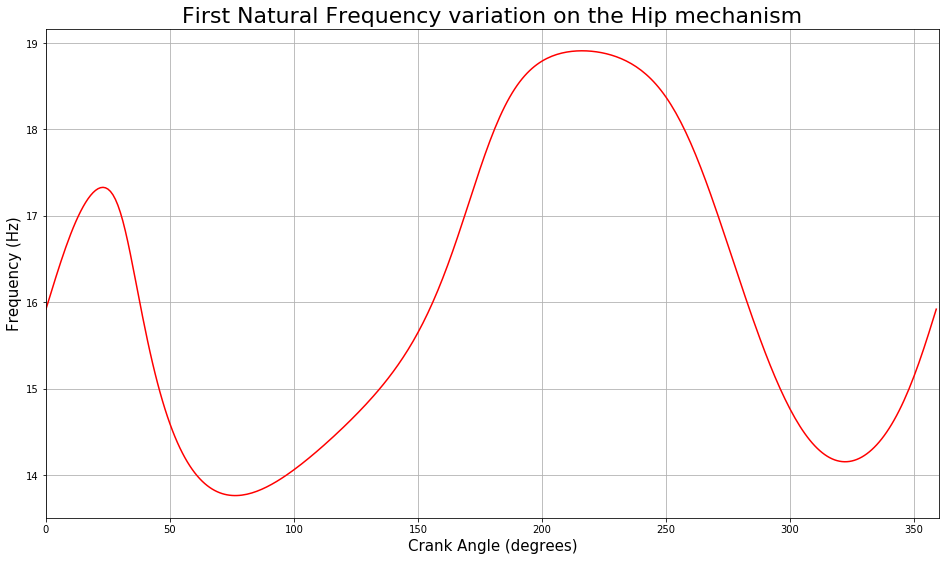

In [17]:
input_angle_in_degrees = np.arange(360)


fig, ax = plt.subplots(figsize=(16,9))


ax.plot(input_angle_in_degrees,first_natural_frequency,'b')
ax.set_xlim([0, 360])
ax.set_title('First Natural Frequency variation on the Hip mechanism',Fontsize=22)
ax.set_xlabel('Crank Angle (degrees)', Fontsize=15)
ax.set_ylabel('Frequency (Hz)', Fontsize=15)
ax.grid()

plt.show()

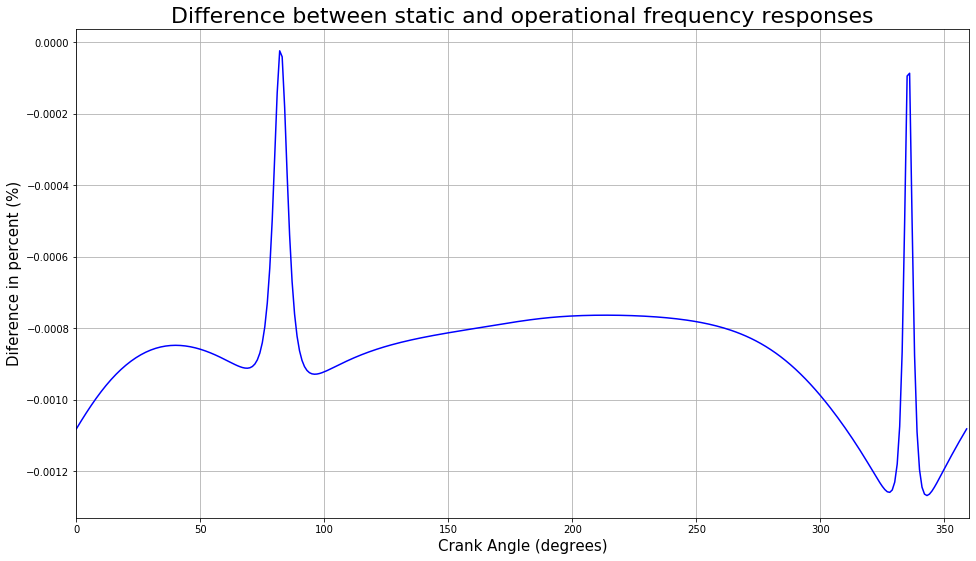

In [18]:
fig, ax = plt.subplots(figsize=(16,9))

response_difference = np.divide(np.array(estatic_response) - np.array(operational_response),np.array(estatic_response))*100

ax.plot(input_angle_in_degrees,response_difference,'b')
ax.set_xlim([0, 360])
ax.set_title('Difference between static and operational frequency responses',Fontsize=22)
ax.set_xlabel('Crank Angle (degrees)', Fontsize=15)
ax.set_ylabel('Diference in percent (%)', Fontsize=15)
ax.grid()

plt.show()

The analysis of the hip mechanism shows similar results with respect to the knee mechanism. Although the first natural frequency oscilates between lower values (between 12 and 19 Hz), they are still far from the operational one, and the difference between the static response is below $12\cdot10^{-6}$ dB.

# Ankle Mechanism

In the ankle mechanism, the external force is applied in the middle of the follower bar. Thus, we defined another analysis function for this mechanism, applying a different conectivity matrix in order the place the force on the correct node.

In [19]:
E=69e7 # Elasticity modulus N/m^2
rho=2700 # Volumetrical density kg/m^3
A = (1e-3*25.4)*(1e-3*12.7)-(1e-3*(25.4-3))*(1e-3*(12.7-3)) # area of the transversal section m^2
inertia = (((1e-3*12.7)*(1e-3*25.4)**3)/12)-((1e-3*(12.7-3)*(1e-3*(25.4-3))**3)/12) #Inertia of the transversal section kg m^2 

lengths = np.array([0.104, 0.235, 0.082, 0.082]) # Bar Lengths (m). IMPORTANT: We treated the extension of the follower bar as separate bar in the FEA.
angles= np.array([0.997609, 0.130134,1.213225,1.213225]) #bar orientations (rad)

P = 33.109 #External Load (N)

In [20]:
def fea_natural_frequencies_ankle(L ,orientations):
    
    FE_per_bar=0           #number of finite elements per bar of the mechanism. Initialized as zero, and increased on the loop
    f_nat=np.ones(6)        #array to keep the first 6 natural frequencies on the current FE configuration.
    f_prev=np.zeros(6)      #array to keep the first 6 natural frequencies on the previous FE configuration.
    error=1e-3              #limit of the relative error
    
    while (max(abs(f_nat-f_prev)) > error) or (FE_per_bar < 20):
        f_prev=f_nat[0:5]
    
        FE_per_bar=FE_per_bar+1  #nEFbarr
        number_of_bars=len(L) #number of bars 
        number_of_FE=FE_per_bar*number_of_bars #nEF
        number_of_nodes=number_of_FE+1 #nNo 
        DOF_per_node=3 #gdn

        boundary_nodes = np.array([0,FE_per_bar*3]) #nodes with imposed boundary conditions (displacement = 0)
        loaded_nodes = np.array([number_of_FE-FE_per_bar+1]) #nodes with external load

        FE_length = L/(FE_per_bar*np.ones(number_of_bars,dtype=int))
        FE_properties = np.zeros((3,number_of_FE))

        aux = 0 #auxiliar integer to delimiter each bar on the properties matrix
        for ii in range(number_of_bars):
            for jj in range(FE_per_bar):
                FE_properties[0,jj+aux] = FE_length[ii]     #Assign FE length on the properties matrix
                FE_properties[1,jj+aux] = orientations[ii]  #Assign FE orientation on the properties matrix
                FE_properties[2,jj+aux] = inertia           #Assign FE inertia on the properties matrix
            aux = aux + FE_per_bar    

        #connectivity matrix (defines the nodes that form each element)
        connectivity_matrix = np.zeros((number_of_FE,2),dtype=int)
        connectivity_matrix[0] =[0,1]
        for ii in range(1,number_of_FE):
            connectivity_matrix[ii] = connectivity_matrix[ii-1] + [1,1]

        #number of Degrees of freedom (global)
        number_of_DOF = number_of_nodes*DOF_per_node
        DOF_matrix = np.arange(number_of_DOF).reshape((number_of_nodes,DOF_per_node))

        connectivity_of_DOFs = np.zeros((number_of_FE,2*DOF_per_node))
        for ii in range(number_of_FE):
            connectivity_of_DOFs[ii] = np.concatenate((DOF_matrix[connectivity_matrix[ii,0]],DOF_matrix[connectivity_matrix[ii,1]]),axis=None)

        connectivity_of_DOFs = connectivity_of_DOFs.astype(int)

        #mechanical system Analysis
        identity_matrix = eye(number_of_DOF)
        M_global = np.zeros((number_of_DOF,number_of_DOF)) #Inertia Matrix
        K_global = np.zeros((number_of_DOF,number_of_DOF)) #Stiffness Matrix

        for ii in range(number_of_FE):
            l=FE_properties[0,ii] #length of the iterated element
            I=FE_properties[2,ii] #Inertia of the iterated element

            #Elementary stiffness on axial direction (X)
            K_elementary_u= E*A/l*np.array([[1, 0, 0, -1, 0, 0],
                                        [0, 0, 0, 0, 0, 0],
                                        [0, 0, 0, 0, 0, 0],
                                        [-1, 0, 0, 1, 0, 0],
                                        [0, 0, 0, 0, 0, 0],
                                        [0, 0, 0, 0, 0, 0]])

            #Elementary stiffness on transversal direction (Y)
            K_elementary_v=E*I/(l**3)*np.array([[0, 0, 0, 0, 0, 0],
                                            [0, 12, 6*l, 0, -12, 6*l],
                                            [0, 6*l, 4*l**2, 0 , -6*l, 2*l**2],
                                            [0, 0, 0, 0, 0, 0],
                                            [0, -12, -6*l, 0, 12, -6*l],
                                            [0, 6*l, 2*l**2, 0 , -6*l, 4*l**2]])
            #Elementary mass matrix
            M_elementary=rho*A*l/420*np.array([[140, 0, 0, 70, 0, 0],
                                 [0, 156, 22*l, 0, 54, -13*l],
                                 [0, 22*l, 4*l**2, 0, 13*l, -3*l**2],
                                 [70, 0, 0, 140, 0, 0],
                                 [0, 54, 13*l, 0, 156, -22*l],
                                 [0, -13*l, -3*l**2, 0, -22*l, 4*l**2]])

            #transformation matrix for orientation
            angle =FE_properties[1,ii]
            Tranform_orientation = np.array([[cos(angle),sin(angle),0,0,0,0],
                                        [-sin(angle),cos(angle),0,0,0,0],
                                        [0,0,1,0,0,0],
                                        [0,0,0,cos(angle),sin(angle),0],
                                        [0,0,0,-sin(angle),cos(angle),0],
                                        [0,0,0,0,0,1]])
            K_elementary_transformed = Tranform_orientation.transpose().dot(K_elementary_u+K_elementary_v).dot(Tranform_orientation)
            M_elementary_transformed = Tranform_orientation.transpose().dot(M_elementary).dot(Tranform_orientation)
            transform_matrix = identity_matrix[connectivity_of_DOFs[ii,0],:]
            for jj in range(1,2*DOF_per_node):
                transform_matrix= np.concatenate((transform_matrix,identity_matrix[connectivity_of_DOFs[ii,jj],:]))
            M_global = M_global + transform_matrix.transpose().dot(M_elementary_transformed).dot(transform_matrix)
            K_global = K_global + transform_matrix.transpose().dot(K_elementary_transformed).dot(transform_matrix)

        #applying the boundary conditions:
        DOF_with_boundary_conditions = DOF_matrix[boundary_nodes].ravel()
        DOF_with_boundary_conditions = DOF_with_boundary_conditions[0:-1]

        #applying the External Forces:
        DOF_with_external_forces = DOF_matrix[loaded_nodes,1]
        DOF_with_external_forces

        #Building the global Forces Array:
        F_global = np.zeros(number_of_DOF)
        F_global[DOF_with_external_forces] = P

        #Eliminating the Known equations from the Mass and Stiffness matrices:
        M_global = np.delete(M_global,DOF_with_boundary_conditions,0)
        M_global = np.delete(M_global,DOF_with_boundary_conditions,1)

        K_global = np.delete(K_global,DOF_with_boundary_conditions,0)
        K_global = np.delete(K_global,DOF_with_boundary_conditions,1)

        F_global = np.delete(F_global,DOF_with_boundary_conditions,0)

        #Solving the eigenvalues and eigenvectors problem
        eig_values,eig_vectors = LA.eig(K_global,M_global)
        natural_frequencies_radians = np.sort(eig_values.real,axis=0)**0.5
        natural_frequencies_herts = natural_frequencies_radians/(2*pi)

        f_nat=natural_frequencies_herts[0:5]
        
        #FRF response
        expected_frequency = 0.2 #hertz
        freq=np.array([0, expected_frequency]) #first value is zero to represent the static response, second value is the expected frequency of the mechanisms
        #df=(freq[-1]-freq[0])/(len(freq)-1)
        w=2*pi*freq

        H=np.zeros(len(freq))
        for ii in range(len(freq)):
            Transfer_function = np.linalg.inv(K_global-w[ii]**2*M_global)
            H[ii] = F_global.transpose().dot(Transfer_function).dot(F_global)

        reference=1e-6
        H = 20*np.log10(abs(H)/reference)
        

        
    return [f_nat, H]


### Importing the mechanism configurations as a DataFrame

In [23]:
#Importing the CSV
ankle_data = pd.read_csv('Data/ankle_data.csv')
ankle_data.head()

,theta_2,theta_3,theta_4
0,0.000000,0.772414,1.574982
1,0.017502,0.761645,1.564369
2,0.035004,0.750886,1.554081
3,0.052506,0.740149,1.544128
4,0.070008,0.729446,1.534520


In [ ]:
#calculating the natural frequencies
first_natural_frequency = list()
estatic_response = list()
operational_response = list()

for ii in range(ankle_data.shape[0]):
    print(f"calculating postition {ii} out of {ankle_data.shape[0]}.")
    for jj in range(ankle_data.shape[1]):
        angles[jj] = ankle_data.iloc[ii,jj]

    angles[-1] = angles[-2]  #since the bar 4 is represented as 2 bars on this analysis, this step is necessary to assign the correct orientation on all elements
    
    [natural_frequencies,frequency_response] = fea_natural_frequencies_ankle(lengths,angles)
    first_natural_frequency.append(natural_frequencies[0])
    estatic_response.append(frequency_response[0])
    operational_response.append(frequency_response[1])

### Creating the plots

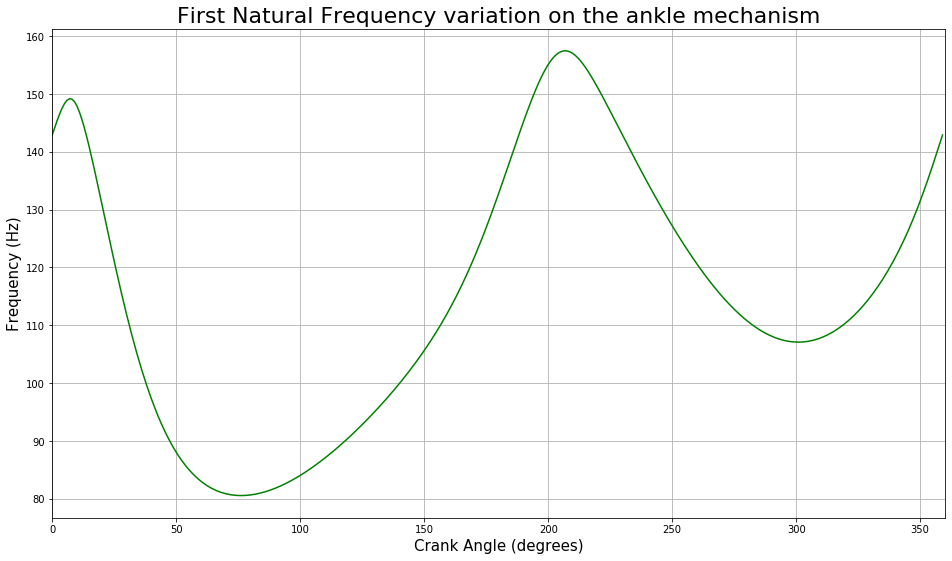

In [25]:
input_angle_in_degrees = np.arange(360)


fig, ax = plt.subplots(figsize=(16,9))


ax.plot(input_angle_in_degrees,first_natural_frequency,'g')
ax.set_xlim([0, 360])
ax.set_title('First Natural Frequency variation on the ankle mechanism',Fontsize=22)
ax.set_xlabel('Crank Angle (degrees)', Fontsize=15)
ax.set_ylabel('Frequency (Hz)', Fontsize=15)
ax.grid()

plt.show()

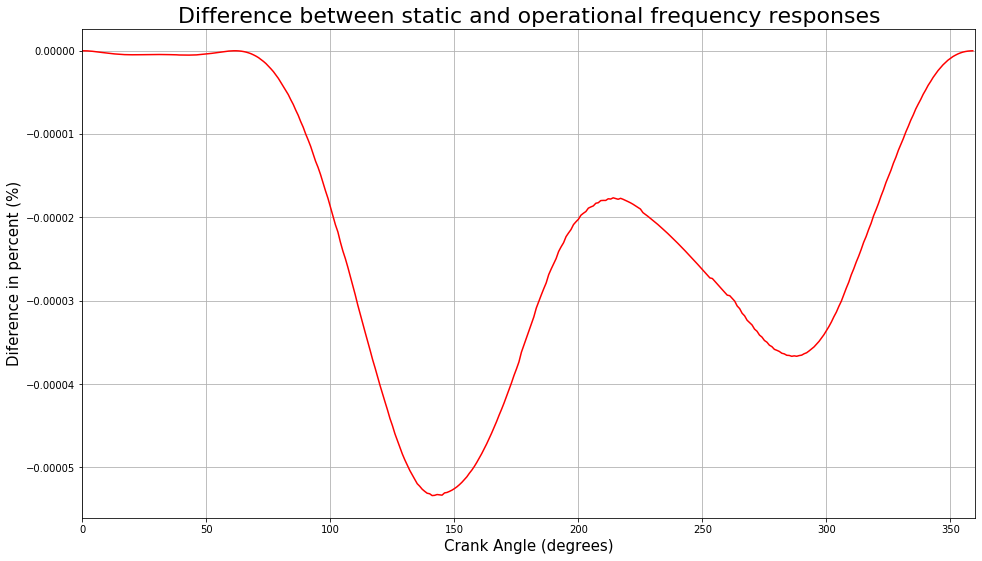

In [26]:
fig, ax = plt.subplots(figsize=(16,9))

response_difference = np.divide(np.array(estatic_response) - np.array(operational_response),np.array(estatic_response))*100

ax.plot(input_angle_in_degrees,response_difference,'r')
ax.set_xlim([0, 360])
ax.set_title('Difference between static and operational frequency responses',Fontsize=22)
ax.set_xlabel('Crank Angle (degrees)', Fontsize=15)
ax.set_ylabel('Diference in percent (%)', Fontsize=15)
ax.grid()

plt.show()

The ankle mechanisms presented the highest values for the first natural frequency, and a difference between static and operational response below $5\cdot10^{-6}$ dB. 

Finally, we can conclude that the dynamic response of the mechanisms on the operational frequency has no significantly differences with respect to the static response. Thus, the quasi-static analysis performed for the transversal section specification of the mechanism is valid and can be used to build the experimental prototypes.
